<p><img alt="Foundry logo" height="38px" src="https://www.foundry.com/favicon.ico" align="left" hspace="10px" vspace="0px"></p>

# Foundry ML Interview Test

The objective of this test is to assess your Machine Learning knowledge and see how you would design and train a model.

This test is separated into three sections:

1. General Machine Learning Q&A
2. Design and train a model
3. Follow-up questions on your model design

This test should take around 1-2 hours to complete.

# Part I. Machine Learning Q&A

Let's consider the following convolution which takes as input a 256x256x3 image:

* Conv: output channels=6, kernel_size=3x3, stride=1, padding=0

**Q1. What is the output size of this convolution? Please write it in the form WxHxC.**

**Answer:** 254x254x3

**Q2. How many parameters does the convolution have? Please explain how you've calculated this.**

**Answer:** (3x3x3+1)x6 = 168.
* Parameters = (kernel_height * kernel_width * input_dimension + bias) * out_channels
* bias referes to the number of filers in the layer

**Q3. Write down the output after convolving this kernel on this input (stride=1):**

In [ ]:
input =  [[a11, a12, a13],
          [a21, a22, a23],
          [a31, a32, a33]]

kernel = [[k11, k12],
          [k21, k22]]

# Please write the full expression e.g. x11 = a11*k11 + a12*k12
output = [[x11, x12],
          [x21, x22]]
# x11 = a11*k11 + a12*k12 + a21*k21 + a22*k22
# x12 = a12*k11 + a13*k12 + a22*k21 + a23*k22
# x21 = a21*k11 + a22*k12 + a31*k21 + a32*k22
# x22 = a22*k11 + a23*k12 + a32*k21 + a33*k22

# Part II. Design and train your model

In this section, we will ask you to design and train a model for the described dataset.

Please note that there is no dataset and no actual training. We are looking at your process designing a model and your understanding of what a training loop would look like.

Your task will be to design an image-to-image model to do human segmentation. Human segmentation takes an RGB image as input and outputs a mask for the human body. See below two data pair examples of what a dataset for this task would look like:

<p><img height="200px" alt="DataExamples" src="https://user-images.githubusercontent.com/27013153/162455925-cb621421-cb57-4343-b9a5-f668c25b21e5.png"/></p>

You are free to select the Machine Learning platform of your choice (PyTorch, Tensorflow, Keras). We currently develop models in PyTorch at Foundry.

### 1. Design a model

In this section, we ask you to design an image-to-image model that could learn human segmentation.

In the ML platform of your choice, please write a model that defines (at least):
* The model layers
* The forward function

We recommend building a model that uses CNN layers.

Your model should be able to take in an input RGB image (3 channels) and give out a mask image (1 channel).

In [2]:
## Design your network
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# import torchvision
# import tochvision.transforms as transforms

class CNN(nn.Module):
  def __init__(self, inchannels = 3, num_classes = 1):
    super(CNN, self).__init__()
    # SAME CONVOLUTION - output after conv2d will remain the same; dimensionalty is not reduced
    self.conv1 = nn.Conv2d(in_channels=inchannels, out_channels=6, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6,out_channels=12, kernel_size=3, stride=1, padding=1)

    self.fc1 = nn.Linear(in_features=12*16*16, out_features=64*64)
    self.sigmoid = nn.Sigmoid()                                                                                                                                                         

  def forward(self, x):
    # first conv layer
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    
    # second conv layer
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)

    # reshape tensor
    x = x.reshape(x.shape[0], -1)

    # fully connected layer
    x = self.fc1(x)
    x = self.sigmoid(x)
    x = x.reshape((4,1,64,64))

    return x


### 2. Write a Training Loop

This sections is about writing an example training loop to train the above model using the ML framework of your choice.

This training loop will use a random mock dataset, not a real one. This is because we are interested in seeing how you would implement each step necessary to train a model, rather than the final accuracy.

Please make sure the code you write can be run directly in this colab without giving errors.

In [3]:
## Training parameters
CHAN_IN = 3
CHAN_OUT = 1
EPOCHS = 100
DATASET_LEN = 50
BATCH_SIZE = 4

PRINT_LOSS_FREQUENCY = 100

## We give a mock train_dataset which is a list of random input and 
## groundtruth data pairs: [[input1, mask1], [input2, mask2], etc.].
import numpy as np
inputs = [torch.rand(BATCH_SIZE, CHAN_IN, 64, 64) for x in range(DATASET_LEN)]
# masks = [torch.rand(BATCH_SIZE, CHAN_OUT, 64, 64) for x in range(DATASET_LEN)]
masks = [torch.round(torch.rand(BATCH_SIZE, CHAN_OUT, 64, 64)) for x in range(DATASET_LEN)]

train_dataset = [[inputs[idx], masks[idx]] for idx in range(DATASET_LEN)]

## Write a training loop that runs for EPOCHS and print the loss for every PRINT_LOSS_FREQUENCY steps
# For example, it could start like this:

model = CNN()
optimiser = optim.Adam(model.parameters()) # default := lr=0.001
loss = nn.MSELoss()

steps = 0
running_loss=0
training_loss = []

fmask = None
fscore = None

print("[*] Start Training")
for epoch in range(EPOCHS):
    for input, mask in train_dataset:

        # forward pass
        scores = model(input)

        l_value = loss(scores, mask)
        training_loss.append(l_value.item())

        running_loss += l_value.item()

        # back pass
        optimiser.zero_grad()
        l_value.backward()

        # use adam to update parameters
        optimiser.step()
        
        fmask = mask
        fscore = scores
        
        if steps%PRINT_LOSS_FREQUENCY == 0:
            train_loss = running_loss/len(train_dataset)
            print("Step: %d: Epoch %d, Training loss %.10f" % (steps, epoch, running_loss))   

        steps += 1



[*] Start Training
Step: 0: Epoch 0, Training loss 0.2505902350
Step: 100: Epoch 2, Training loss 25.3075560182
Step: 200: Epoch 4, Training loss 50.2466325462
Step: 300: Epoch 6, Training loss 75.1170169860
Step: 400: Epoch 8, Training loss 99.8002192676
Step: 500: Epoch 10, Training loss 123.7154983878
Step: 600: Epoch 12, Training loss 144.3471462727
Step: 700: Epoch 14, Training loss 156.4683915973
Step: 800: Epoch 16, Training loss 162.1368213259
Step: 900: Epoch 18, Training loss 165.9308636561
Step: 1000: Epoch 20, Training loss 168.5085234381
Step: 1100: Epoch 22, Training loss 169.4480618136
Step: 1200: Epoch 24, Training loss 169.7567538489
Step: 1300: Epoch 26, Training loss 169.9671406418
Step: 1400: Epoch 28, Training loss 170.1360967534
Step: 1500: Epoch 30, Training loss 170.2805783454
Step: 1600: Epoch 32, Training loss 170.4073471965
Step: 1700: Epoch 34, Training loss 170.5198316856
Step: 1800: Epoch 36, Training loss 170.6199739902
Step: 1900: Epoch 38, Training loss

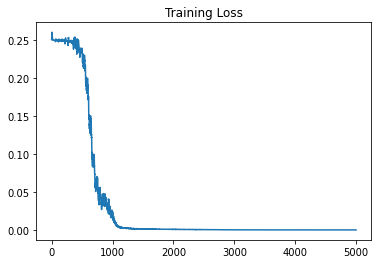

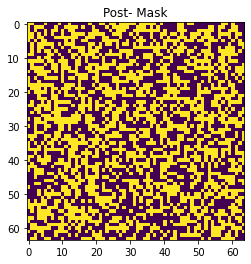

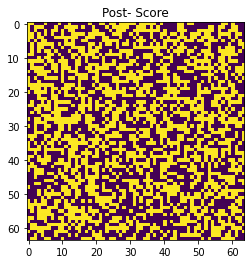

In [4]:
# plt.imshow(torch.squeeze(fscore[0]).detach().numpy())

plt.title("Training Loss"); plt.plot(training_loss)
plt.figure(); plt.title("Post- Mask"); plt.imshow( torch.squeeze(fmask[0]).detach().numpy()) 
plt.figure(); plt.title("Post- Score"); plt.imshow( torch.squeeze(fscore[0]).detach().numpy()) 

# Part III. Analyse your model

In this section, we would like you to explain some of your decisions in designing and training your model.

This is all about understanding **why** you picked some options over others.

**Q1. Why did you choose this optimiser?**

**Answer:** I made the choice to use ADAM optimiser instead of SGD. As the model is a generative problem as opposed to a classification problem, ADAM provides a separate learning rate for each parameter, allowing the model to better understand how to alter each pixel to reach the target image during training. After testing both, it was clear that ADAM allowed the model to learn differences much quicker than SGD did.

**Q2. If your model is overfitting, can you describe one or two ways to prevent it?**

**Answer:**  Including a regularization function to penalize complex models can reduce complexity of the algorithm and in turn, reduce loss. This can prevent the model from placing importance or rejecting specific features. Additionally, a dropout function can be used to deactivate a percentage of nodes during training for a more thorough search of the search space, reducing senstivity to specific traits. 

**Q3. Why did you choose this loss function? If this was a classification problem, what loss do you think would be more appropriate?**

**Answer:** I chose an Mean Squarred Error loss function aka squarred l2 norm. I made this choice because of its ability to evaluate a pixel wise difference. Therefore, using it, allows the Network to calculate the difference in pixel values from the mask to the test/training image. The Larger the difference, the larger the loss.

If it was a classification problem, with multiple classes, I would have chosen a Cross Entropy Loss function with a softmax classification function. If there was a binary classification I would have chosen a Binary Cross Entropy loss function with a sigmoind classification.

**Q4. If you had more time to design this model, describe two things that you would add to improve the accuracy of this model.**

**Answer:** A technique used to increase accuracy is shuffling and splitting the dataset. Shuffling the training data can get rid of a potential bias the algorithm may develop, and in turn, increase accuracy. 

If I had more time and a proper dataset to test with, I would firstly follow the 80/20 rule to split my dataset into trainig set and validation set. This would allow me to get a better gage of the accuracy of my model while also reducing overfitting. With a proper accuracy metric I would then implement K-Fold cross validation to improve my models accuracy. K-Fold cross validation trains the model over multiple iterations of the dataset. It splits the training and validation set differently at every batch and uses the new training set to continue training the same model k times.

Additionally, I would use some sort of data augmentation to create variations of data from the dataset, increasing the dataset length with new valid data. These augmentations could be in the form of image rotations, colour variations, etc. Differences which alter current items in the dataset to produce new entries to the dataset. This would provide a larger sample size for the model to train off and better understand what it must be doing, reducing overfitting and increasing accuracy. 

**Q5. If you needed to speed up the inference time of this model, describe one thing that you might try.**

**Answer:** One thing that could be done is to redesign the model in a way that reduces the number of layers and parameters. The larger the number of parameters, the larger the number of calculations that will need to be processed. Thus, finding a model which can complete the same task with a smiliar accuracy can reduce complexity in training and also speed up inference time.

# That's it, well done!